# PARAMETER IDENTIFICATION NOTEBOOK

In this notebook we leverage the pretrained surrogate models to identify the generating transmissivity fiels.\
We start from noisy signals. The noise is an additive white noise, manually added to the data to emulate experimental data. 

##### Importing necessary libraries

In [9]:
# Standard library imports
import sys

import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['KERAS_BACKEND'] = 'tensorflow'

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import arviz as az
import timeit

import scipy.stats as stats
from keras.models import Sequential
from keras.layers import Dense, Concatenate
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.models import load_model

#Try with TinyDA
import tinyDA as tda
from scipy.stats import multivariate_normal
from scipy.stats import uniform


# Local module imports
sys.path.append('./src/SurrogateModeling')
sys.path.append('./src/InverseProblems')
sys.path.append('./src/utils')
from utils import * 
from plotting import *
from random_process import *
from model import Model


#### Decide sample to use for experimental data

In [10]:
sample = 16 # Which sample of the training set do wou want to take as experimental input?
OUTPUT_FILENAME = "./samples/sample_coarse_"+str(sample)

#### Set Bayesian Identification Parameters

In [11]:
noise = 0.001

#### Load Surrogate Models

In [12]:
# Extract test data for visualization or further processing
n_eig = 64
X_values = np.loadtxt('./data/X_test_64000.csv', delimiter = ',')
y_values = np.loadtxt('./data/y_test_64000.csv',delimiter = ',')

High Fidelity model

In [13]:
# Set up the model(s)
solver_pod = Model(resolution = [25,25], field_mean = 1, field_stdev = 1, mkl = 64, lamb = 0.1)

b = np.loadtxt("./POD_basis2.csv", delimiter=',')

In [14]:
model_pod = Sequential()

# Add layers to the model
model_pod.add(Dense(256, input_shape=(128,), activation='gelu'))
model_pod.add(Dense(256, activation='gelu'))
model_pod.add(Dense(256, activation='gelu'))
model_pod.add(Dense(25, activation='sigmoid'))

model_pod = load_model('./models/model_MF_POD_1.keras')

def model_hf(x):
    solver_pod.solve(x)
    x_new = np.hstack((x,solver_pod.random_process.random_field @ b)).reshape((1,128))
    return np.array(model_pod(x_new)).reshape(25)

/Users/lucacaroselli/miniconda3/envs/fenics/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Load Low Fidelity Model

In [15]:
model_l = Sequential()
model_l.add(Dense(128, input_shape=(64,), activation='gelu'))
model_l.add(Dense(128, activation='gelu'))
model_l.add(Dense(64, activation='gelu'))
model_l.add(Dense(25, activation='exponential'))

model_l =  load_model('./models/model_LF_64000_3.keras')

def model_lf (input):
    return np.array(model_l(input.reshape((1,64)))).reshape(25)

### Define observation, prior and likelyhood

In [16]:
# Select a true sample for testing
x_true, y_true = X_values[sample], y_values[sample]

# Generate observed data by adding Gaussian noise to the true data
y_observed = y_true + np.random.normal(scale=noise,size=y_true.shape[0])

# Define the prior distribution for the input parameters
x_distribution = stats.multivariate_normal(mean = np.zeros(n_eig), cov = np.eye(n_eig))

# Set the likelihood
cov_likelihood = noise * np.eye(25)
y_distr_coarse = tda.GaussianLogLike(y_observed, cov_likelihood)
y_distr_fine   = tda.GaussianLogLike(y_observed, cov_likelihood)

#### Perform least square optimization for each starting point

In [24]:
# Initialize a list to hold the optimized parameters for each start point
initial_guesses = []

# Display the true parameters for reference
print("Real Params: ", x_true)

bounds = (-5*np.ones(n_eig), 5*np.ones(n_eig))

# Iterate over each parameter start point to perform optimizatio
# Perform least squares optimization given the observed data, forward model,
# start point, and parameter bounds
optimized_params, covariance_matrix = least_squares_optimization(
        y_observed=y_observed, 
        forward_model=model_lf , 
        start_point=np.zeros(n_eig), 
        bounds=bounds
    )

# Append the optimized parameters to the list of initial guesses
initial_guesses.append(optimized_params)

# Print the optimized parameters for this iteration
print(f"Optimized Params : {optimized_params}")


Real Params:  [ 1.1537516   1.59930096  1.0712466   0.16285143 -1.77693013  1.13429878
 -0.93495814  2.69019167  0.62724265  2.43673345 -0.56867574 -0.14274359
 -2.2278197  -0.75301225 -1.62102912  1.00922652  1.91294232 -0.85850774
 -2.31511961  2.52755889  0.09154126 -0.29053499 -0.53602897  0.34754535
 -0.01173919  1.17243121 -1.22188369 -0.96913818 -0.39950806  1.01188892
 -1.20621682 -0.87489908  0.57811353 -0.52530346 -1.09333604  1.10048611
  0.91836686  1.14180672  0.48037021  1.52078407  1.50176772  0.74254826
  0.04931592 -0.34914246  1.8694958   1.63233869 -1.17102144  1.14337158
  0.92133669  0.30800992 -0.87071644 -0.604474    0.22870254  0.15959755
  0.5696756  -0.17067527  0.27926433 -1.32688715  0.87618644  0.16703566
 -0.26100612  0.29748849  1.39345466 -0.99058778]
Optimized Params : [ 0.05852408  0.63720629  0.7771911   0.40919364 -1.81361179  1.53104101
 -1.0425991   1.60079541  1.0271284   1.60925458 -0.1719474  -0.4965495
 -1.33801362 -0.14376404 -0.20422044  0.64

#### Do Metropolis Hastings Sampling

Set the parameters for the algorithm 

In [35]:
scaling = 0.175
n_iter =  22000 #55000
burnin = 2000 #5000
thin = 20
sub_sampling = 4

In [36]:
#cov = np.diag(np.linspace(1,5,n_eig))
cov = np.eye(n_eig)

In [37]:
# initialise the LinkFactory
my_posterior_fine = tda.Posterior(x_distribution, y_distr_fine, model_hf)
my_posterior_coarse = tda.Posterior(x_distribution, y_distr_coarse, model_lf)

my_posteriors = [my_posterior_coarse, my_posterior_fine]

# random walk Metropolis
#my_proposal = tda.GaussianRandomWalk(C=cov, scaling= scaling)
my_proposal = tda.CrankNicolson(scaling=scaling, adaptive=False, gamma = 1.01, period=100)

In [38]:
# Initialize a list to hold the Markov chain samples for each initial guess
samples_mh = []
ESS_values = []

# Iterate over each initial guess to set up and run the Markov chain sampler
start_0 = timeit.default_timer() 
for index, initial_guess in enumerate(initial_guesses):
    samples = tda.sample(my_posteriors, my_proposal,
                          iterations=n_iter, n_chains=1,
                            subsampling_rate = sub_sampling,
                              initial_parameters=np.zeros(64))
    idata = tda.to_inference_data(samples, level='fine')
    # Remove the burnin and sub-sample
    idata = idata.sel(draw=slice(burnin, None, thin), groups="posterior")
    # Append the samples to the list
    samples_mh.append(idata)
    ess = az.ess(idata)
    # Compute and print the Effective Sample Size (ESS) of the first set of samples
    print("Effective Sample Size: ", ess,"\n\n\n")
end_0 = timeit.default_timer() 

# Computing diagnostics and collecting results
#print("\nRhat: ", az.rhat(az.concat(samples_mh, dim = 'chain')))

#print('Mean ESS:' , np.mean(ESS_values, axis = 0))
#print('Time/ESS MDA',(end_0-start_0)/(5*np.mean(ESS_values, axis = 0)) )




Sampling chain 1/1


Running chain, α_c = 0.328, α_f = 0.53: 100%|██████████| 22000/22000 [07:02<00:00, 52.04it/s]
/Users/lucacaroselli/miniconda3/envs/fenics/lib/python3.11/site-packages/arviz/data/inference_data.py:157: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 512B
Dimensions:  ()
Data variables: (12/64)
    x0       float64 8B 90.22
    x1       float64 8B 28.75
    x2       float64 8B 51.87
    x3       float64 8B 158.7
    x4       float64 8B 88.1
    x5       float64 8B 123.9
    ...       ...
    x58      float64 8B 97.71
    x59      float64 8B 93.58
    x60      float64 8B 86.07
    x61      float64 8B 133.0
    x62      float64 8B 85.31
    x63      float64 8B 119.1 





Let's look at the trace plot of one chain

# Diagnostics 

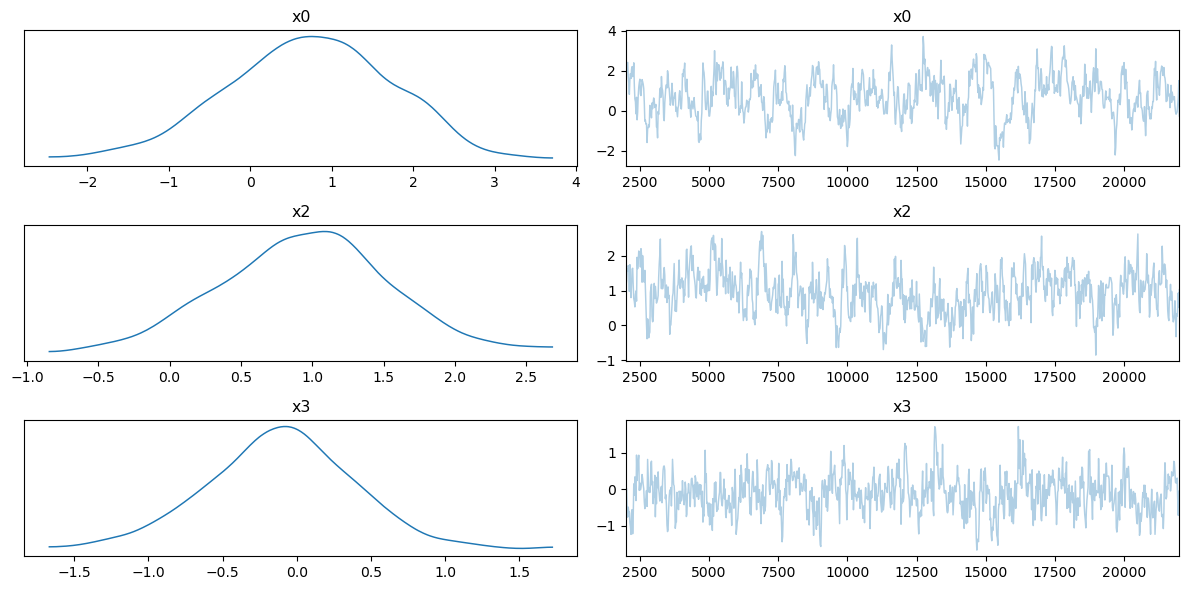

In [39]:
# Plot trace of the first set of samples
az.plot_trace(idata, var_names=['x0', 'x2', 'x3'])
plt.tight_layout()
plt.show()


Let's compare the prediction of the mean parameter combination and the experimental signal

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

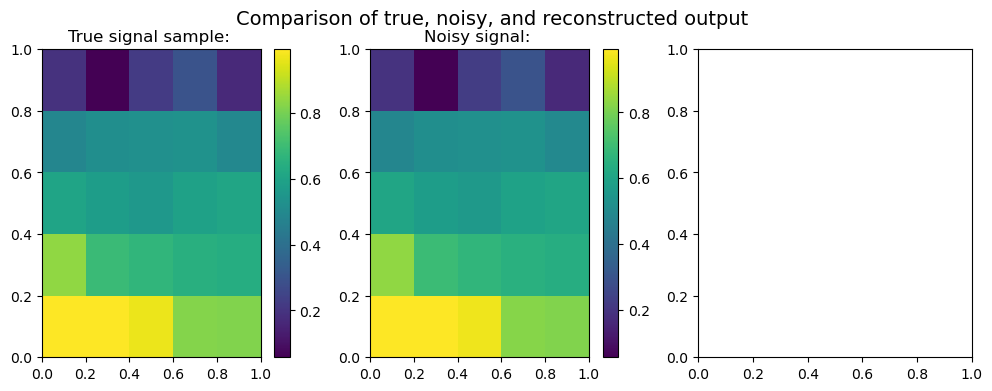

In [42]:
# Plotting and data collection
data = tda.get_samples(samples)['chain_0'][burnin:n_iter:thin, :]
plot_results( y_true, y_observed, model_hf, data, n_eig, x_true)

Finally, let's look at the parameters distribution

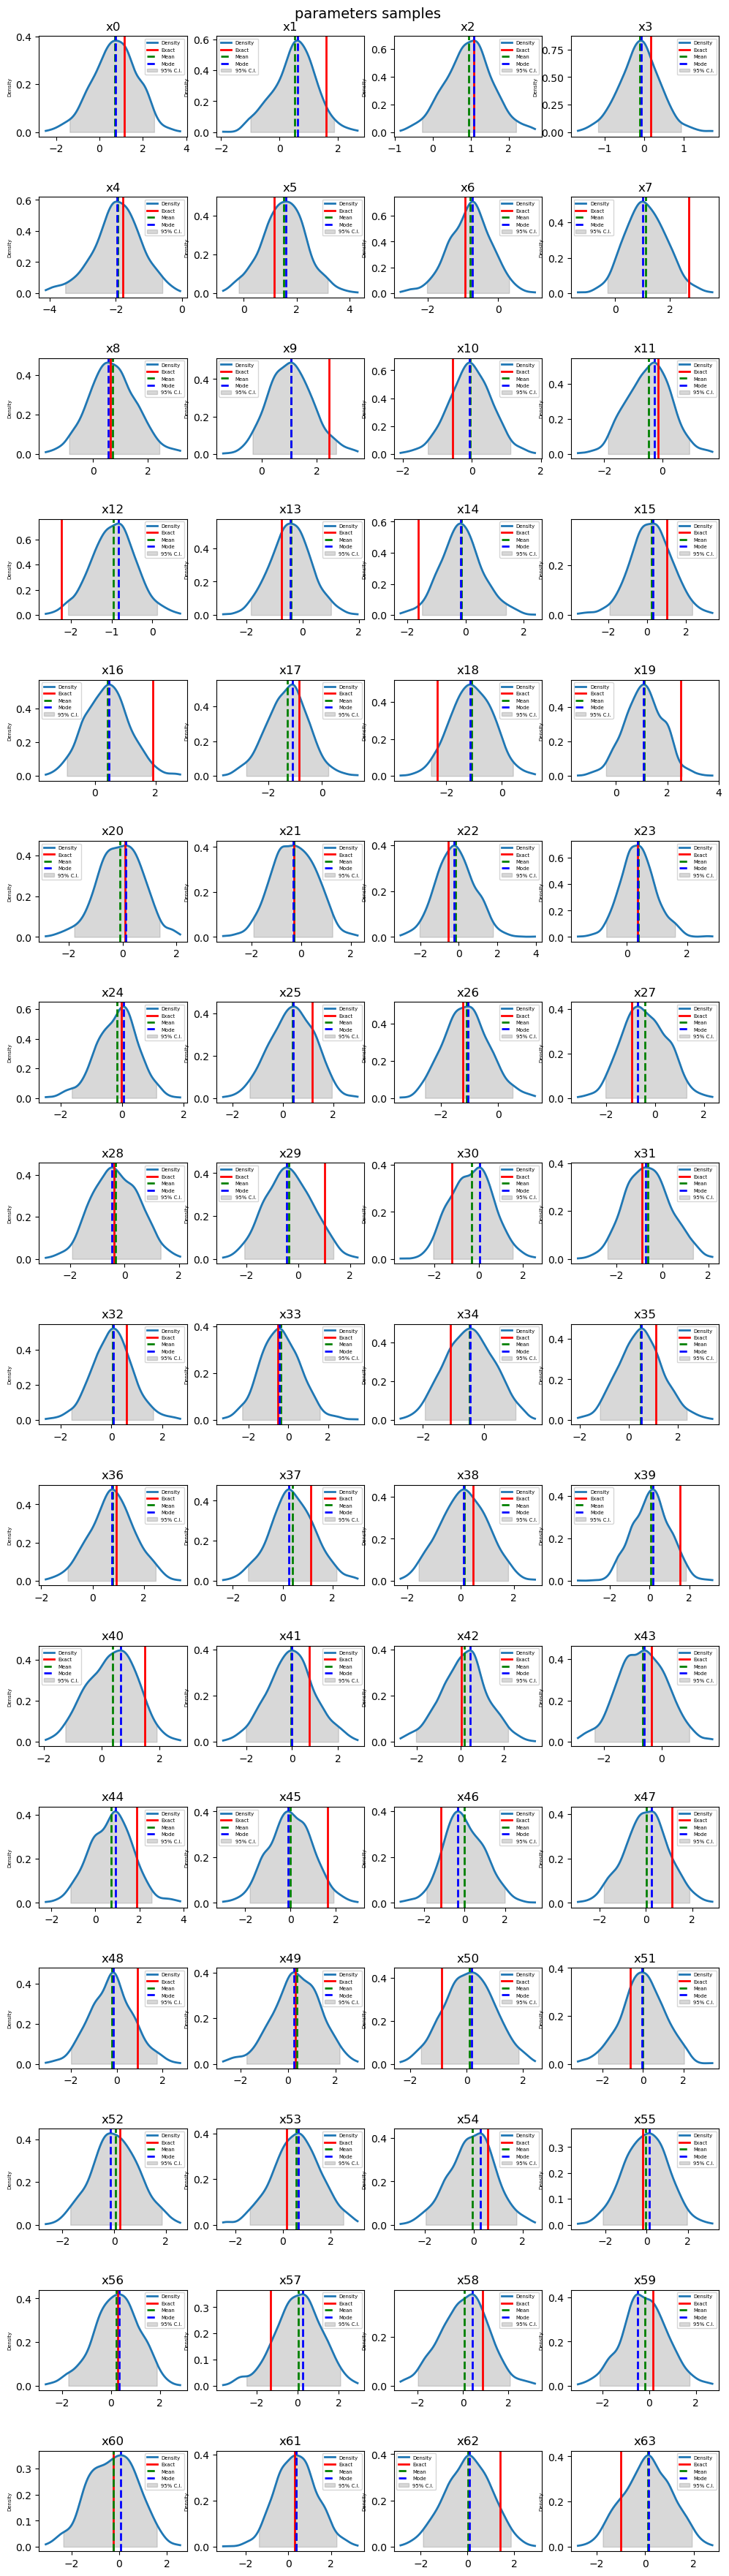

In [43]:
keys = ['x'+ str(i) for i in range(64)]
plot_parameter_distributions(data, x_true, keys, n_eig) 

### Reconstructed field 

<Figure size 1000x400 with 0 Axes>

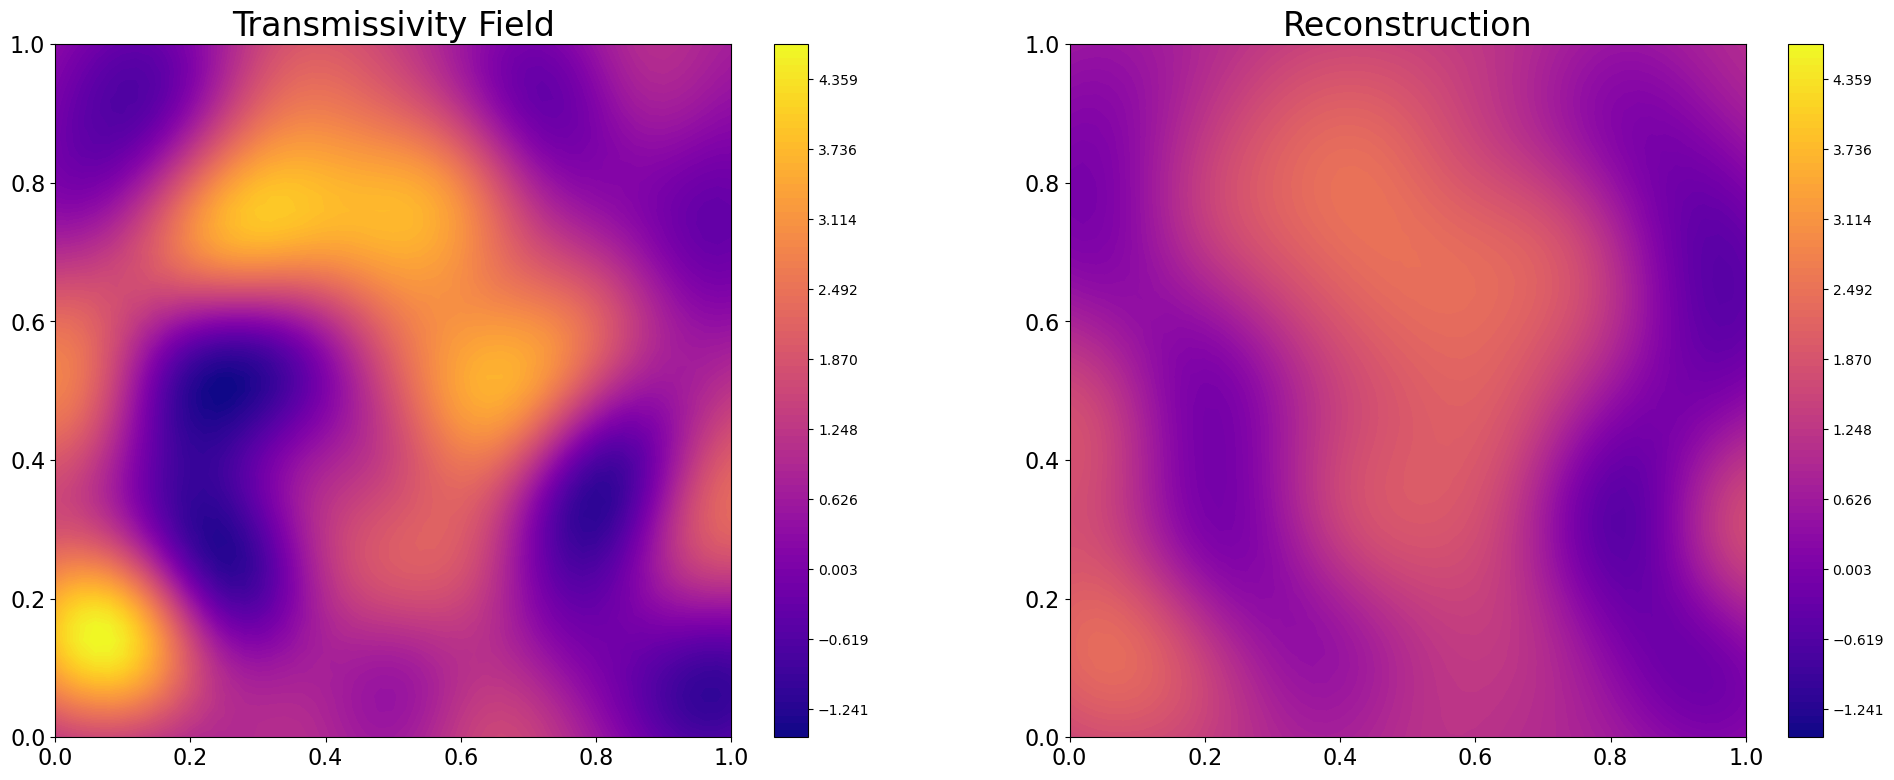

In [45]:
plot_fields(x_true=x_true, x_estimated=data.mean(axis=0),n_eig=n_eig, lognormal=False)

# Different parameters

### Higher SSR

In [48]:
noise = 0.001
scaling = 0.175
n_iter =  22000 #55000
burnin = 2000 #5000
thin = 5
sub_sampling = 10


y_observed = y_true + np.random.normal(scale=noise,size=y_true.shape[0])

# LIKELYHOOD
cov_likelihood = noise * np.eye(25)
y_distr_coarse = tda.GaussianLogLike(y_observed, cov_likelihood)
y_distr_fine   = tda.GaussianLogLike(y_observed, cov_likelihood)  

# initialise the LinkFactory
my_posterior_fine = tda.Posterior(x_distribution, y_distr_fine, model_hf)
my_posterior_coarse = tda.Posterior(x_distribution, y_distr_coarse, model_lf)
my_posteriors = [my_posterior_coarse, my_posterior_fine]

my_proposal = tda.CrankNicolson(scaling=scaling, adaptive=False, gamma = 1.01, period=100)

# RUN THE MCMC
samples = tda.sample(my_posteriors, my_proposal, iterations=n_iter, n_chains=1, initial_parameters=np.zeros(64))
idata = tda.to_inference_data(samples, level='fine')
# Remove the burnin and sub-sample
idata = idata.sel(draw=slice(burnin, None, thin), groups="posterior")
ess = az.ess(idata)
# Compute and print the Effective Sample Size (ESS) of the first set of samples
print("Effective Sample Size: ", ess,"\n\n\n")

Sampling chain 1/1


Running chain, α_c = 0.140, α_f = 0.12: 100%|██████████| 22000/22000 [02:17<00:00, 159.73it/s]
/Users/lucacaroselli/miniconda3/envs/fenics/lib/python3.11/site-packages/arviz/data/inference_data.py:157: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 512B
Dimensions:  ()
Data variables: (12/64)
    x0       float64 8B 31.6
    x1       float64 8B 23.57
    x2       float64 8B 30.05
    x3       float64 8B 76.22
    x4       float64 8B 42.79
    x5       float64 8B 42.41
    ...       ...
    x58      float64 8B 28.57
    x59      float64 8B 26.85
    x60      float64 8B 34.37
    x61      float64 8B 7.068
    x62      float64 8B 36.37
    x63      float64 8B 25.69 





<Figure size 1000x400 with 0 Axes>

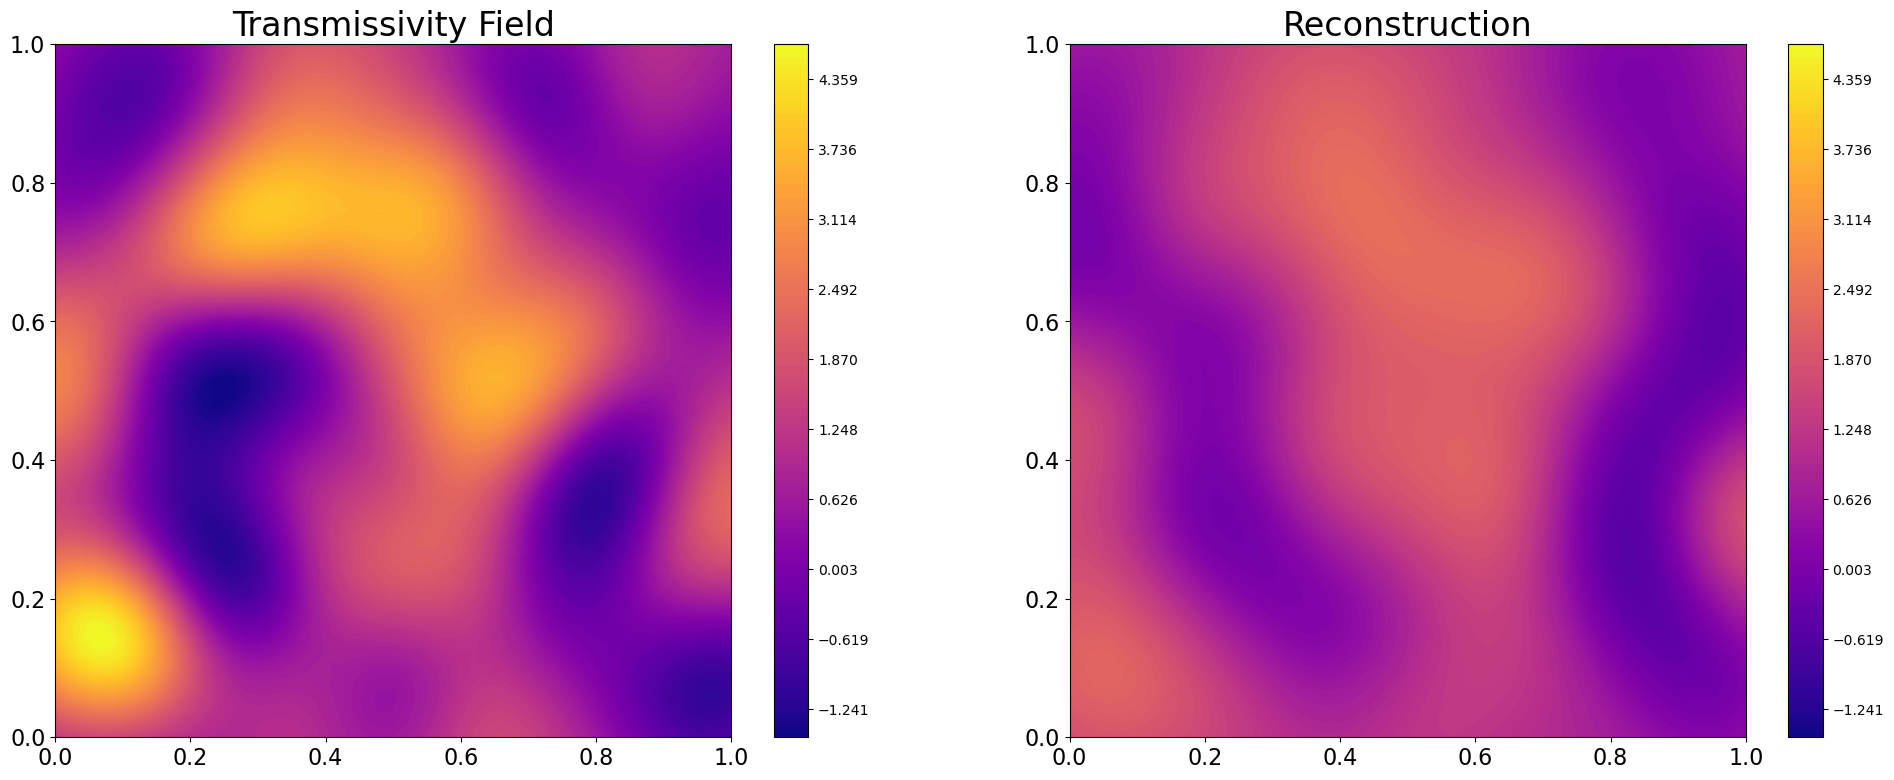

In [49]:
data = tda.get_samples(samples)['chain_0'][burnin:n_iter:thin, :]
plot_fields(x_true=x_true, x_estimated=data.mean(axis=0),n_eig=n_eig, lognormal=False)

### Lower SSR

In [60]:
noise = 0.001
scaling = 0.175
n_iter =  27000 #55000
burnin = 3000 #5000
thin = 25
sub_sampling = 2


y_observed = y_true + np.random.normal(scale=noise,size=y_true.shape[0])

# LIKELYHOOD
cov_likelihood = noise * np.eye(25)
y_distr_coarse = tda.GaussianLogLike(y_observed, cov_likelihood)
y_distr_fine   = tda.GaussianLogLike(y_observed, cov_likelihood)  

# initialise the LinkFactory
my_posterior_fine = tda.Posterior(x_distribution, y_distr_fine, model_hf)
my_posterior_coarse = tda.Posterior(x_distribution, y_distr_coarse, model_lf)
my_posteriors = [my_posterior_coarse, my_posterior_fine]

my_proposal = tda.CrankNicolson(scaling=scaling, adaptive=False, gamma = 1.01, period=100)

# RUN THE MCMC
samples = tda.sample(my_posteriors, my_proposal, iterations=n_iter, n_chains=1, initial_parameters=np.zeros(64))
idata = tda.to_inference_data(samples, level='fine')
# Remove the burnin and sub-sample
idata = idata.sel(draw=slice(burnin, None, thin), groups="posterior")
ess = az.ess(idata)
# Compute and print the Effective Sample Size (ESS) of the first set of samples
print("Effective Sample Size: ", ess,"\n\n\n")

Sampling chain 1/1


Running chain, α_c = 0.220, α_f = 0.19: 100%|██████████| 27000/27000 [02:47<00:00, 161.01it/s]
/Users/lucacaroselli/miniconda3/envs/fenics/lib/python3.11/site-packages/arviz/data/inference_data.py:157: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 512B
Dimensions:  ()
Data variables: (12/64)
    x0       float64 8B 40.92
    x1       float64 8B 59.99
    x2       float64 8B 50.46
    x3       float64 8B 82.55
    x4       float64 8B 35.4
    x5       float64 8B 60.16
    ...       ...
    x58      float64 8B 25.28
    x59      float64 8B 45.03
    x60      float64 8B 30.18
    x61      float64 8B 27.37
    x62      float64 8B 51.59
    x63      float64 8B 29.82 





In [ ]:
data = tda.get_samples(samples)['chain_0'][burnin:n_iter:thin, :]
plot_fields(x_true=x_true, x_estimated=data.mean(axis=0),n_eig=n_eig, lognormal=False)

Lower likelyhood

In [67]:
noise = 0.001
scaling = 0.03
n_iter =  22000 #55000
burnin = 2000 #5000
thin = 20
sub_sampling = 4


y_observed = y_true + np.random.normal(scale=noise,size=y_true.shape[0])

# LIKELYHOOD
cov_likelihood = noise * np.eye(25)
y_distr_coarse = tda.GaussianLogLike(y_observed, cov_likelihood*0.1)
y_distr_fine   = tda.GaussianLogLike(y_observed, cov_likelihood*0.1)  

# initialise the LinkFactory
my_posterior_fine = tda.Posterior(x_distribution, y_distr_fine, model_hf)
my_posterior_coarse = tda.Posterior(x_distribution, y_distr_coarse, model_lf)
my_posteriors = [my_posterior_coarse, my_posterior_fine]

my_proposal = tda.CrankNicolson(scaling=scaling, adaptive=False, gamma = 1.01, period=100)

# RUN THE MCMC
samples = tda.sample(my_posteriors, my_proposal, iterations=n_iter, n_chains=1, initial_parameters=np.zeros(64))
idata = tda.to_inference_data(samples, level='fine')
# Remove the burnin and sub-sample
idata = idata.sel(draw=slice(burnin, None, thin), groups="posterior")
ess = az.ess(idata)
# Compute and print the Effective Sample Size (ESS) of the first set of samples
print("Effective Sample Size: ", ess,"\n\n\n")

Sampling chain 1/1


Running chain, α_c = 0.350, α_f = 0.11: 100%|██████████| 22000/22000 [03:16<00:00, 111.98it/s]
/Users/lucacaroselli/miniconda3/envs/fenics/lib/python3.11/site-packages/arviz/data/inference_data.py:157: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 512B
Dimensions:  ()
Data variables: (12/64)
    x0       float64 8B 8.175
    x1       float64 8B 11.16
    x2       float64 8B 1.808
    x3       float64 8B 2.124
    x4       float64 8B 1.804
    x5       float64 8B 2.102
    ...       ...
    x58      float64 8B 3.149
    x59      float64 8B 9.073
    x60      float64 8B 6.288
    x61      float64 8B 2.022
    x62      float64 8B 1.371
    x63      float64 8B 2.068 





<Figure size 1000x400 with 0 Axes>

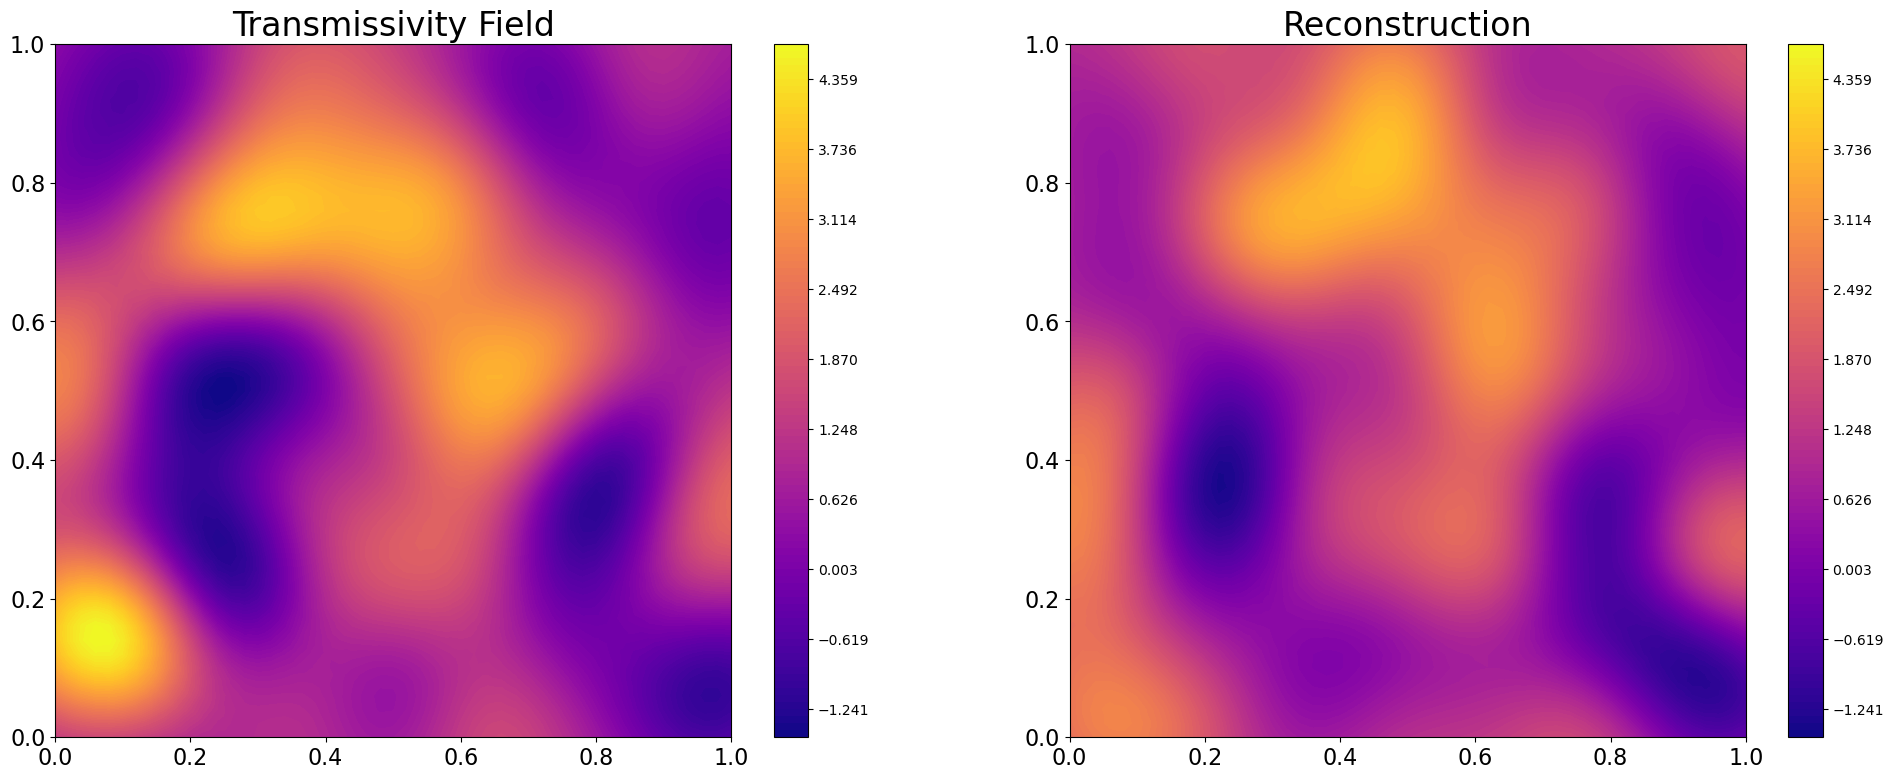

In [68]:
data = tda.get_samples(samples)['chain_0'][burnin:n_iter:thin, :]
plot_fields(x_true=x_true, x_estimated=data.mean(axis=0),n_eig=n_eig, lognormal=False)

### Lower (right) likelyhood 

In [70]:
noise = 0.001
scaling = 0.01
n_iter =  22000 #55000
burnin = 2000 #5000
thin = 20
sub_sampling = 4


y_observed = y_true + np.random.normal(scale=noise,size=y_true.shape[0])

# LIKELYHOOD
cov_likelihood = noise**2 * np.eye(25)
y_distr_coarse = tda.GaussianLogLike(y_observed, cov_likelihood)
y_distr_fine   = tda.GaussianLogLike(y_observed, cov_likelihood)  

# initialise the LinkFactory
my_posterior_fine = tda.Posterior(x_distribution, y_distr_fine, model_hf)
my_posterior_coarse = tda.Posterior(x_distribution, y_distr_coarse, model_lf)
my_posteriors = [my_posterior_coarse, my_posterior_fine]

my_proposal = tda.CrankNicolson(scaling=scaling, adaptive=False, gamma = 1.01, period=100)

# RUN THE MCMC
samples = tda.sample(my_posteriors, my_proposal, iterations=n_iter, n_chains=1, initial_parameters=np.zeros(64))
idata = tda.to_inference_data(samples, level='fine')
# Remove the burnin and sub-sample
idata = idata.sel(draw=slice(burnin, None, thin), groups="posterior")
ess = az.ess(idata)
# Compute and print the Effective Sample Size (ESS) of the first set of samples
print("Effective Sample Size: ", ess,"\n\n\n")

Sampling chain 1/1


Running chain, α_c = 0.210, α_f = 0.00: 100%|██████████| 22000/22000 [03:41<00:00, 99.53it/s] 
/Users/lucacaroselli/miniconda3/envs/fenics/lib/python3.11/site-packages/arviz/data/inference_data.py:157: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 512B
Dimensions:  ()
Data variables: (12/64)
    x0       float64 8B 1.395
    x1       float64 8B 1.303
    x2       float64 8B 2.987
    x3       float64 8B 1.464
    x4       float64 8B 1.298
    x5       float64 8B 1.302
    ...       ...
    x58      float64 8B 1.305
    x59      float64 8B 1.364
    x60      float64 8B 10.26
    x61      float64 8B 6.191
    x62      float64 8B 1.493
    x63      float64 8B 7.316 





In [ ]:
data = tda.get_samples(samples)['chain_0'][burnin:n_iter:thin, :]
plot_fields(x_true=x_true, x_estimated=data.mean(axis=0),n_eig=n_eig, lognormal=False)

### Higher noise 

### NO Noise 